# LangChain: Q&A over Documents

In [ ]:
#pip install --upgrade langchain

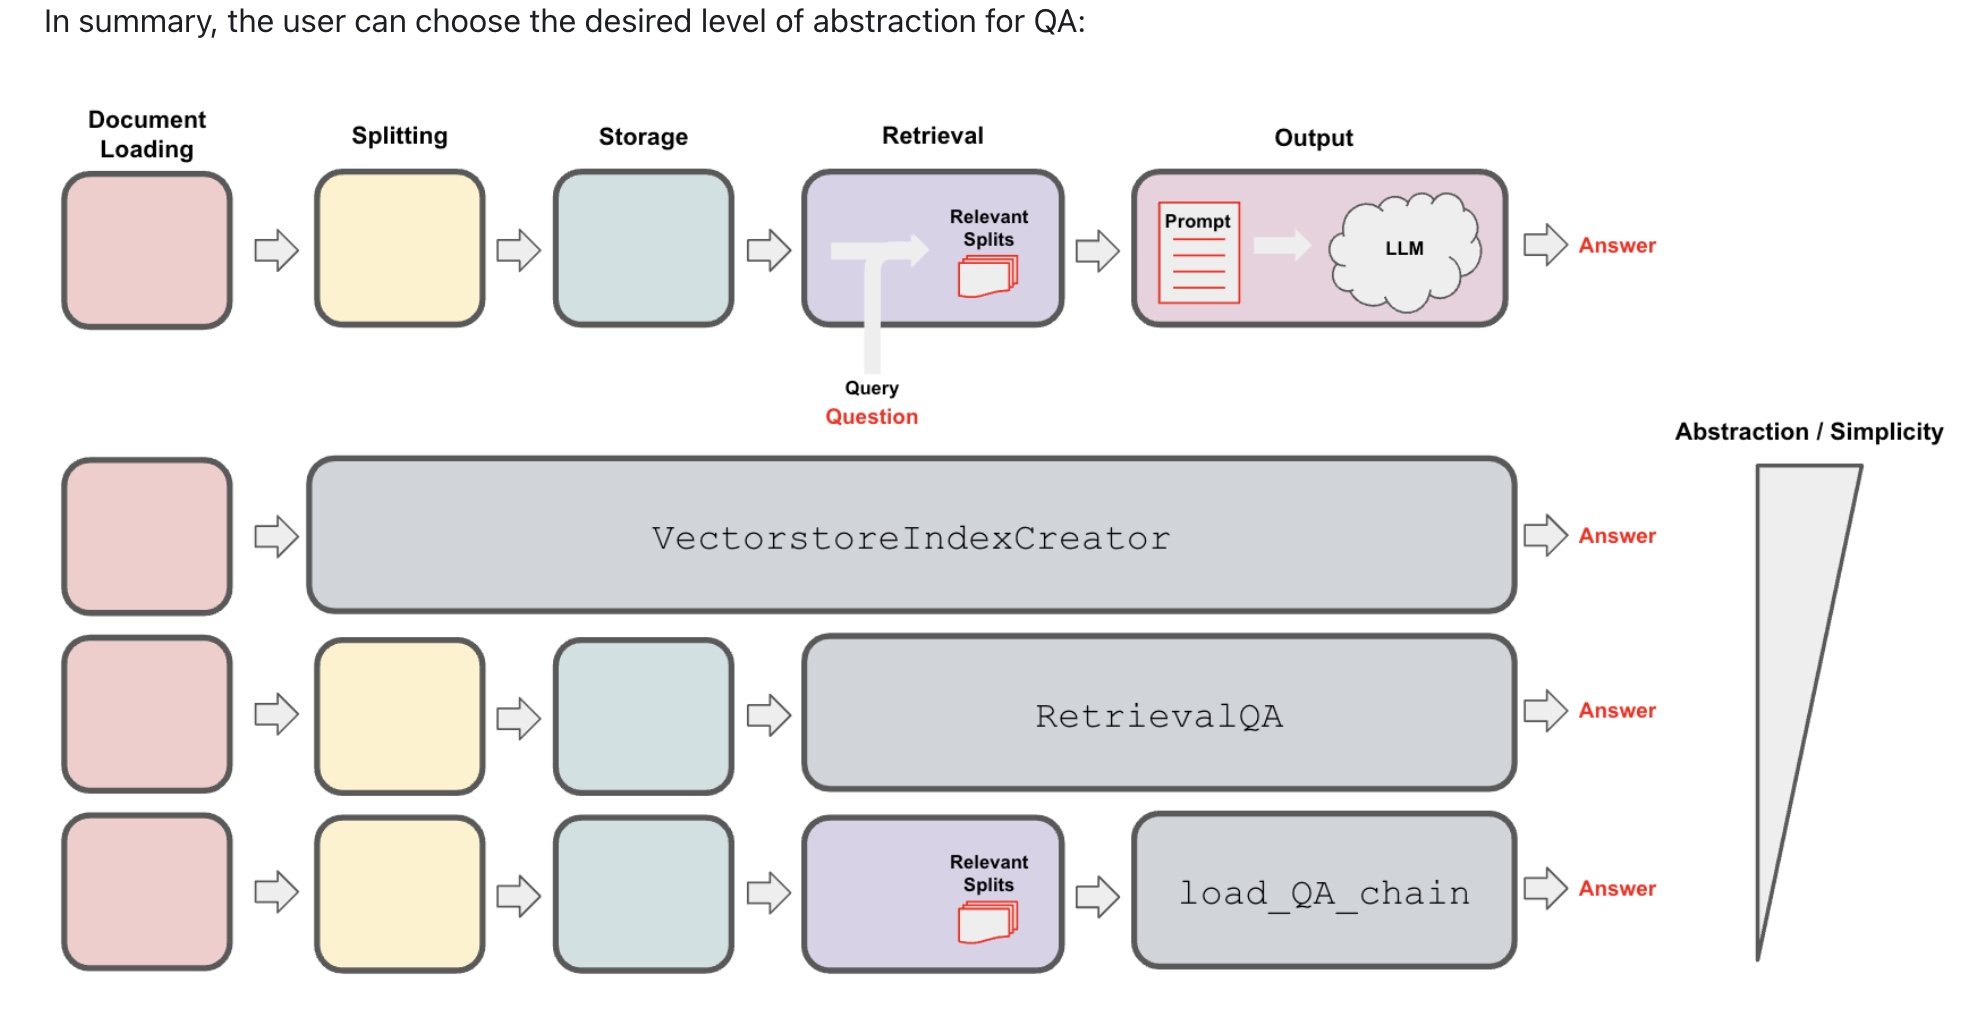

In [ ]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [ ]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader
from langchain.vectorstores import DocArrayInMemorySearch
from IPython.display import display, Markdown

In [ ]:
file = 'OutdoorClothingCatalog_1000.csv'
loader = CSVLoader(file_path=file)

In [ ]:
#pip install docarray

In [ ]:
from langchain.indexes import VectorstoreIndexCreator

index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch
).from_loaders([loader])

query ="Please list all your shirts with sun protection \
in a table in markdown and summarize each one."

response = index.query(query)

display(Markdown(response))



| Name | Description |
| --- | --- |
| Men's Tropical Plaid Short-Sleeve Shirt | UPF 50+ rated, 100% polyester, wrinkle-resistant, front and back cape venting, two front bellows pockets |
| Men's Plaid Tropic Shirt, Short-Sleeve | UPF 50+ rated, 52% polyester and 48% nylon, machine washable and dryable, front and back cape venting, two front bellows pockets |
| Men's TropicVibe Shirt, Short-Sleeve | UPF 50+ rated, 71% Nylon, 29% Polyester, 100% Polyester knit mesh, machine wash and dry, front and back cape venting, two front bellows pockets |
| Sun Shield Shirt by | UPF 50+ rated, 78% nylon, 22% Lycra Xtra Life fiber, handwash, line dry, wicks moisture, fits comfortably over swimsuit, abrasion resistant |

All four shirts provide UPF 50+ sun protection, blocking 98% of the sun's harmful rays. The Men's Tropical Plaid Short-Sleeve Shirt is made of 100% polyester and is wrinkle-resistant

### Embeddings

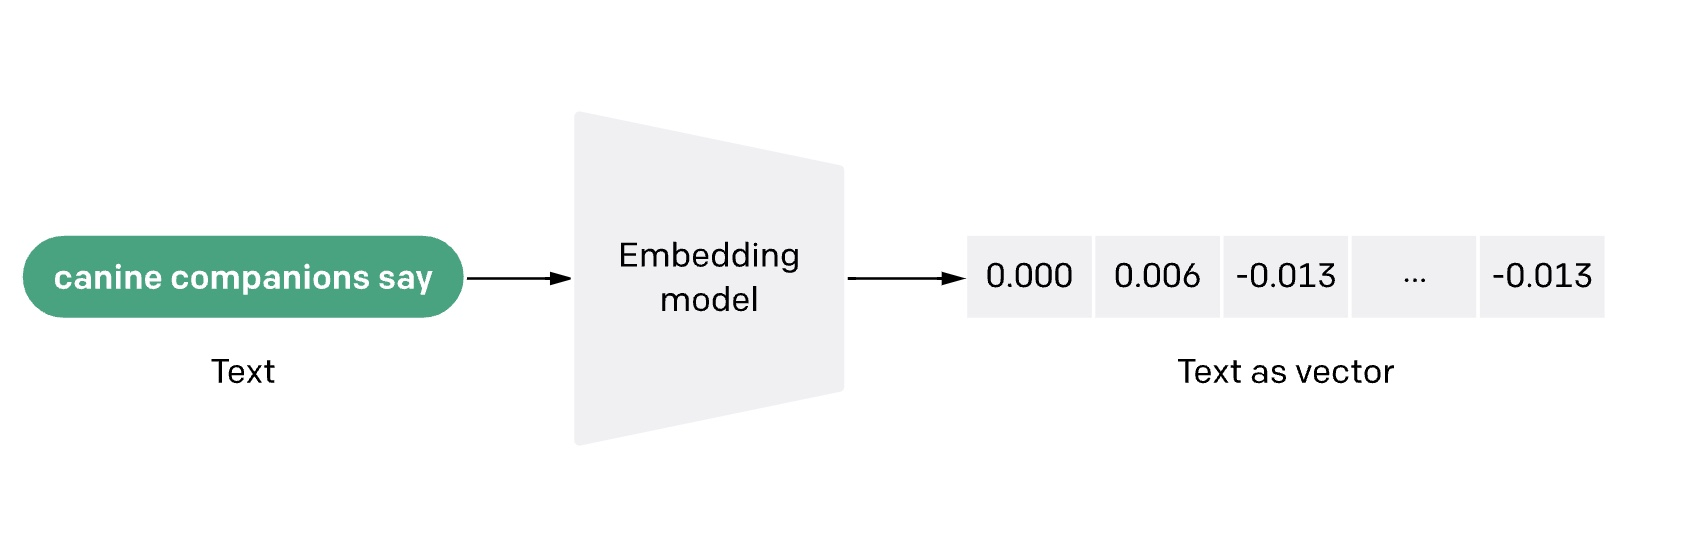

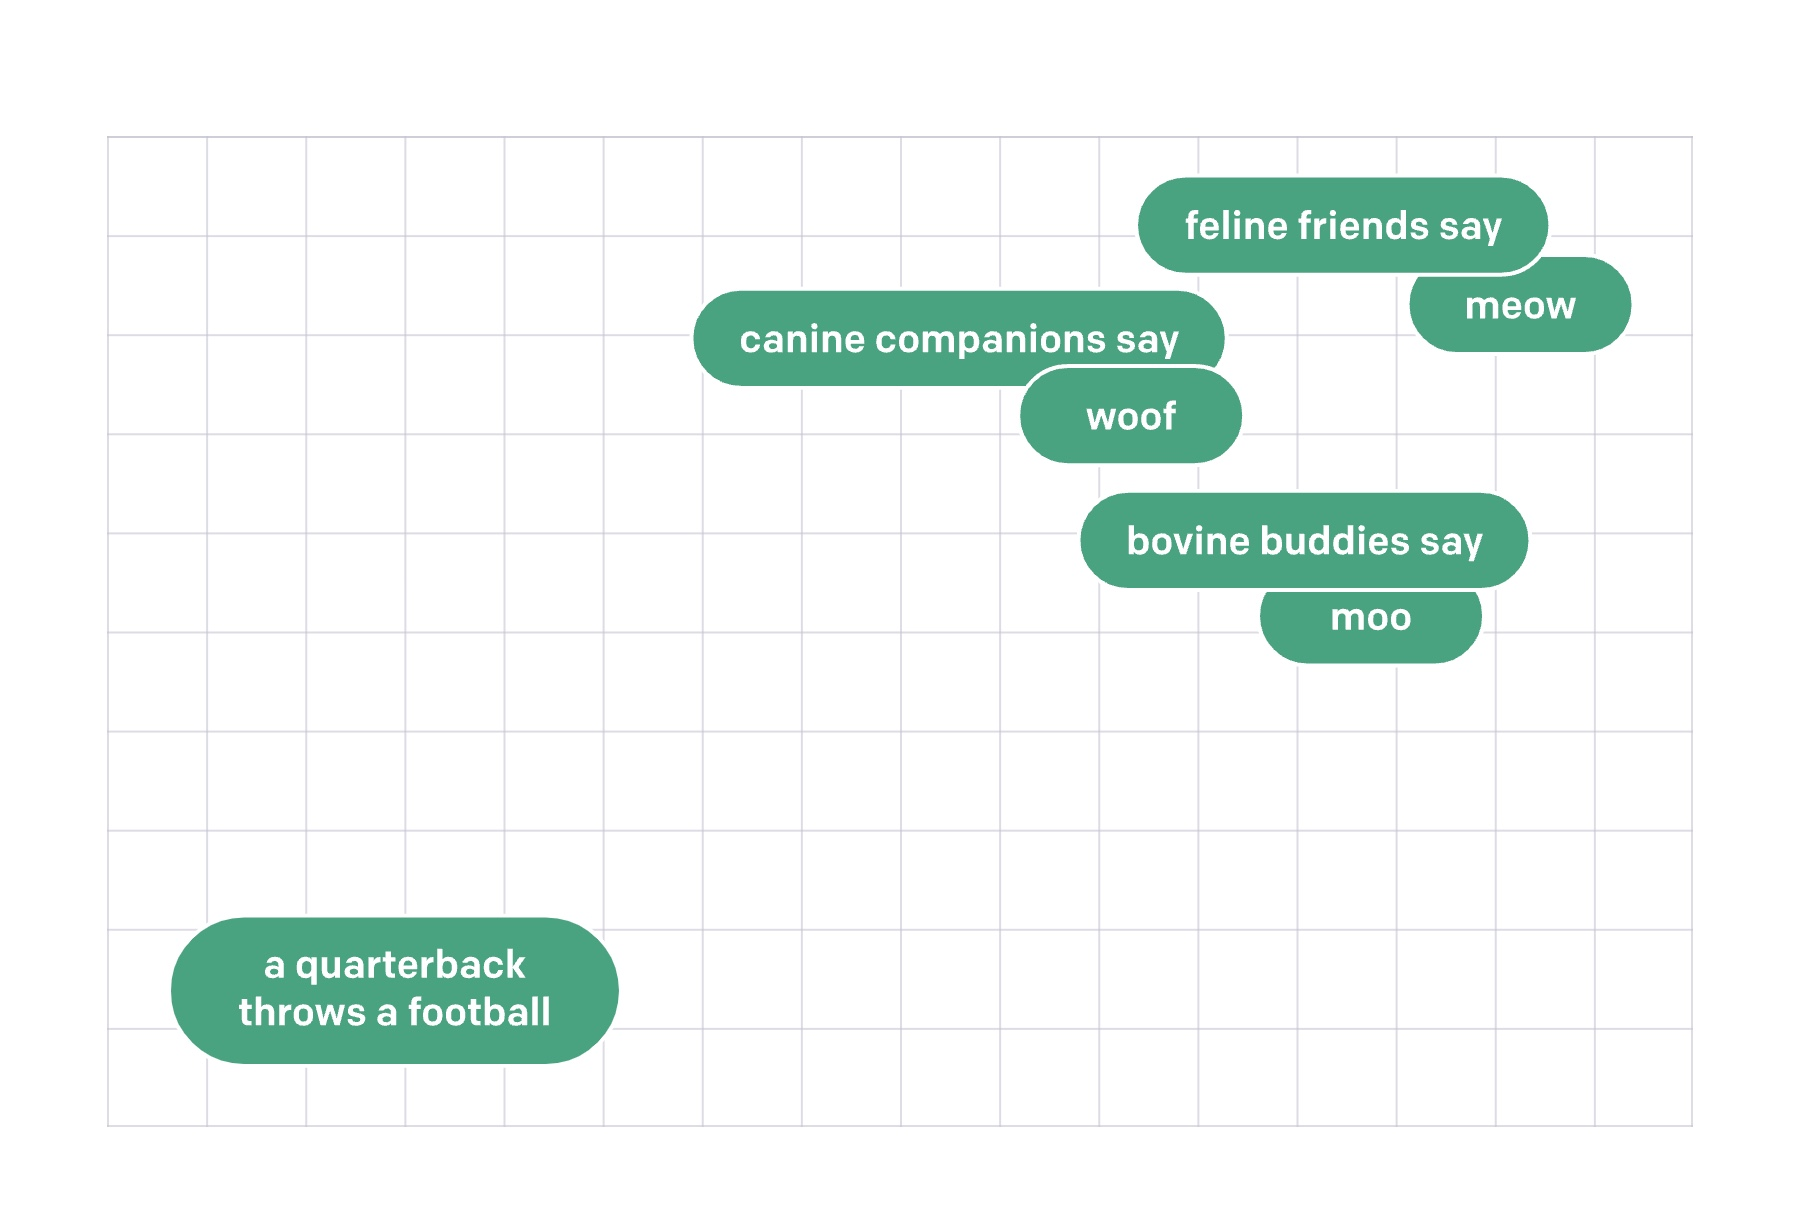

In [ ]:
docs = loader.load()

In [ ]:
docs[0]

Document(page_content=": 0\nname: Women's Campside Oxfords\ndescription: This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on. \n\nSize & Fit: Order regular shoe size. For half sizes not offered, order up to next whole size. \n\nSpecs: Approx. weight: 1 lb.1 oz. per pair. \n\nConstruction: Soft canvas material for a broken-in feel and look. Comfortable EVA innersole with Cleansport NXT® antimicrobial odor control. Vintage hunt, fish and camping motif on innersole. Moderate arch contour of innersole. EVA foam midsole for cushioning and support. Chain-tread-inspired molded rubber outsole with modified chain-tread pattern. Imported. \n\nQuestions? Please contact us for any inquiries.", metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 0})

In [ ]:
from langchain.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()
db = DocArrayInMemorySearch.from_documents(
    docs,
    embeddings
)
query = "Please suggest a shirt with sunblocking"
returned_docs = db.similarity_search(query)
print(len(returned_docs))
docs[0]

4


Document(page_content=': 255\nname: Sun Shield Shirt by\ndescription: "Block the sun, not the fun – our high-performance sun shirt is guaranteed to protect from harmful UV rays. \n\nSize & Fit: Slightly Fitted: Softly shapes the body. Falls at hip.\n\nFabric & Care: 78% nylon, 22% Lycra Xtra Life fiber. UPF 50+ rated – the highest rated sun protection possible. Handwash, line dry.\n\nAdditional Features: Wicks moisture for quick-drying comfort. Fits comfortably over your favorite swimsuit. Abrasion resistant for season after season of wear. Imported.\n\nSun Protection That Won\'t Wear Off\nOur high-performance fabric provides SPF 50+ sun protection, blocking 98% of the sun\'s harmful rays. This fabric is recommended by The Skin Cancer Foundation as an effective UV protectant.', metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 255})

In [ ]:
question="What is the Women's Ultraplush Sweats made of?"

llm = ChatOpenAI(temperature = 0.0)
from langchain.chains import RetrievalQA
qa_chain = RetrievalQA.from_chain_type(llm,retriever=db.as_retriever())
qa_chain({"query": question})

{'query': "What is the Women's Ultraplush Sweats made of?",
 'result': "The Women's Ultraplush Sweats are made of 95% cotton and 5% spandex."}

In [ ]:
# Customizing the prompt

from langchain.prompts import PromptTemplate
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.
{context}
Question: {question}
Helpful Answer:"""

question="What's today's weather like"

QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template,)

qa_chain = RetrievalQA.from_chain_type(llm,
                                       retriever=db.as_retriever(),
                                       chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})

result = qa_chain({"query": question})
result["result"]

"I don't know, sorry. Thanks for asking!"

In [ ]:
from langchain.chains.question_answering import load_qa_chain
question = "Should I wear the Fleece Jacket on a hot summer day?"
chain = load_qa_chain(llm, chain_type="stuff")
chain({"input_documents": docs, "question": question},return_only_outputs=True)


{'output_text': 'No, you should not wear the Fleece Jacket on a hot summer day.'}

Sources:
- https://openai.com/blog/introducing-text-and-code-embeddings
- https://python.langchain.com/docs/use_cases/question_answering/#32-going-deeper